# Lab 2 - W203 - Statistics for Data Science

#### Submission by Jude Kavalam, Harshit Patel, Abhi Sharma

## Install packages

In [15]:
install.packages("dplyr")
library(dplyr)
install.packages("rcompanion")
library(rcompanion)
install.packages("repr")
library(repr)
# set standard height and width for images displayed
options(repr.plot.width=5, repr.plot.height=5)


  There is a binary version available but the source version is later:
      binary source needs_compilation
dplyr  0.8.4  0.8.5              TRUE

  Binaries will be installed


Warning message:
"package 'dplyr' is in use and will not be installed"Warning message:
"package 'rcompanion' is in use and will not be installed"Warning message:
"package 'repr' is in use and will not be installed"

## Get Data Function

In [16]:
get_data = function() {
    wd = getwd()
    return (read.csv(paste(wd, "/", "anes_pilot_2018.csv", sep="")))    
}


In [17]:
data = get_data()
head(data)

,version,caseid,weight,weight_spss,form,follow,addtime,reg,whenreg,howreg,...,rand_emp,rand_climate,rand_rural,rand_pk,rand_pid,starttime,endtime,duration,optintimestamp,completes
,<fct>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<int>
1,ANES 2018 Pilot Study main version 20190129,1,1.2555080,0.7286969,1,4,2,1,4,-1,...,1,2,2,1,1,12/10/2018 18:34:11,12/10/2018 20:00:03,5152,10/15/15,46
2,ANES 2018 Pilot Study main version 20190129,2,0.5694911,0.3305327,2,1,2,3,-1,-1,...,2,1,1,0,2,12/10/2018 19:26:37,12/10/2018 19:53:12,1595,7/16/16,55
3,ANES 2018 Pilot Study main version 20190129,3,0.9720616,0.5641846,1,4,3,3,-1,-1,...,2,2,1,1,2,12/10/2018 19:48:44,12/10/2018 20:21:21,1957,6/13/14,8
4,ANES 2018 Pilot Study main version 20190129,4,2.4500732,1.4220225,1,4,2,1,4,-1,...,2,2,1,0,1,12/10/2018 19:03:49,12/10/2018 19:21:08,1039,10/28/15,42
5,ANES 2018 Pilot Study main version 20190129,5,1.6348200,0.9488495,2,1,3,1,4,-1,...,2,1,2,1,2,12/10/2018 18:28:14,12/10/2018 18:43:23,909,11/11/15,33
6,ANES 2018 Pilot Study main version 20190129,6,1.8184054,1.0554025,1,3,2,2,2,2,...,1,2,1,1,2,12/10/2018 23:58:17,12/11/2018 5:10:57,18760,5/9/15,185


In [18]:
nrow(data)


[1] 2500

In [19]:
ncol(data)


[1] 767

In [20]:
length(data)

[1] 767

Data context: https://electionstudies.org/wp-content/uploads/2019/02/anes_pilot_2018_userguidecodebook.pdf 

Questionnaire: https://electionstudies.org/wp-content/uploads/2018/12/anes_pilot_2018_questionnaire.pdf

## Filter Functions

Here are some generic functions that help slice the data in convenient ways which can be used across all the research questions

In [21]:
filter_skp = function(df, skp_prefix, skp_values) {
    skp_col = paste(skp_prefix, "_skp", sep = "")
    return (df %>% filter(df[, skp_col] %in% skp_values))
}

# Usage
# x = filter_skp(data, "ftpolice", c(0,1))
# nrow(x)

In [22]:
filter_timing = function(df, timing_prefix, time_threshold) {
    timing_col = paste(timing_prefix, "_page_timing", sep= "")
    return (df %>% filter(df[, timing_col] <= time_threshold))
}

# Usage
# x = filter_timing(data, "ftpolice", 10)
# nrow(x)
# summary(x$ftpolice_page_timing)

In [23]:
filter_honest = function(df, honest_vals) {
    return (df %>% filter(df[, "honest"] %in% honest_vals))
}

#Freq. Numeric Label
#37      1     Never
#46      2     Some of the time
#90      3     About half the time
#215     4     Most of the time
#2112    5     Always

# Usage
# x = filter_honest(data, c(1))
# nrow(x)


In [24]:
filter_nonserious = function(df, ns_vals) {
    return (df %>% filter(df[, "nonserious"] %in% ns_vals))
}

#Freq. Numeric Label
#2007    1     Never
#157     2     Some of the time
#109     3     About half the time
#55      4     Most of the time
#172     5     Always

# Usage
# x = filter_nonserious(data, c(1))
# nrow(x)

## Question 1: Do US voters have more respect for the police or for journalists?

### Introduce your topic briefly. (5 points)
Will need to use ftpolice (How would you rate the police?) and ftjournal (How would you rate journalists?)

These are measured on a thermal scale (ordinal) from 0 to 100. The variables capturing the rating are:
1. ftpolice_therm for ftpolice
2. ftjournal_therm for ftjournal

The key assumption we're making here is that these ratings (ftpolice and ftjournal) are being used to measure "respect levels" for these professions. This is a reasonable assumption given that there are no other variables to capture this sentiment.

Its important to call out the ordinal nature of the scale and how a value of 55 for respondent 1 may differ from the same value of 55 for respondent 2. In other words, **the same score for a group (say police) may have different meanings for different respondents.**

However, the score of ftpolice = 90 and ftjournal = 55 for a particular respondent shows that the respondent in question has more respect for police than journalists. In other words, **different scores for the same respondent on the 2 groups have comparable interpretation.** 

Hence, the data captured is in pairs. For each respondent, we have 2 scores and we can compare these scores to form proportions of voters that like the police vs journalists.

### Perform an exploratory data analysis (EDA) of the relevant variables. (5 points)
 
There are certain variables of interest along which we can slice the number of respondents we consider in the test:

First we create a base data set (called q1_data):

**1. honest** <br/>
This represents respondents who answered the survey honestly. To get reliable results, **we will only consider respondents who are honest for this question.** It is important that we consider responses where people feel honest when answering questions regarding respect for professionals in police vs journalism.

**2. ftpolice_page_timing and ftjournal_page_timing** <br/>
This represents the time taken for a respondent to answer the corresponding questions (ftpolice and ftjournal). The reason why this may have been potentially interesting is because if a respondent takes too long to answer the question, then he / she maynot be sure about how they feel about the police / journalists. The 90th percentile for each variable seems to be within 12 seconds, which seems like a reasonable time to answer the question "without hestitation". **We will further explore this variable and discard responses > (say) 30 seconds.**

**3. nonserious** <br/>
This represents respondents who had degrees of nonserious-ness in the survey. **We will consider respondents who have values for nonserious=[1,2,3] as our entire population.** We want only serious candidates to be considered when answering a question like this. 

Next, we consider further slicing our base data set (q1_data) based on certain attributes:

**1. ftpolice_skp and ftjournal_skp** <br/>
This represents the variable where a candidate was asked a question, but decided to skip the question the first time around. This may reveal the hesitant nature of the respondent to answer the question directly. Hence, we will check the percentage of our base data set to determine how many respondents skipped these questions. If this distribution is fairly large, we will consider doing 2 sets of tests (where skp=0 vs considering all skp values).

**2. nonserious** <br/>
We will check what percentage of the base data set population is very serious (ie, nonserious=1) and will make a decision to further conduct a separate test with only a very serious population (or not).


In [25]:
# EDA for ftpolice_page_timing
d = get_data()
paste("Summary for ftpolice_page_timing")
summary(d$ftpolice_page_timing)

paste("Number of ftpolice_page_timing > 30 seconds")
nrow(d[d$ftpolice_page_timing > 30,])
# note that we will remove the 33 rows that are > 30 seconds in response time

[1] "Summary for ftpolice_page_timing"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.014   3.732   5.263   7.503   7.894 650.031 

[1] "Number of ftpolice_page_timing > 30 seconds"

[1] 33

In [26]:
# EDA for ftjournal_page_timing
paste("Summary for ftjournal_page_timing")
summary(d$ftjournal_page_timing)

paste("Number of ftjournal_page_timing >= 30 seconds")
nrow(d[d$ftjournal_page_timing > 30,])
# note that we will remove the 29 rows that are > 30 seconds in response time

[1] "Summary for ftjournal_page_timing"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.857   3.628   5.005   6.559   7.394 109.647 

[1] "Number of ftjournal_page_timing >= 30 seconds"

[1] 29

[1] "Summary for honest"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   5.000   5.000   4.728   5.000   5.000 

[1] "Percentage of always honest respondents"

[1] 84.48

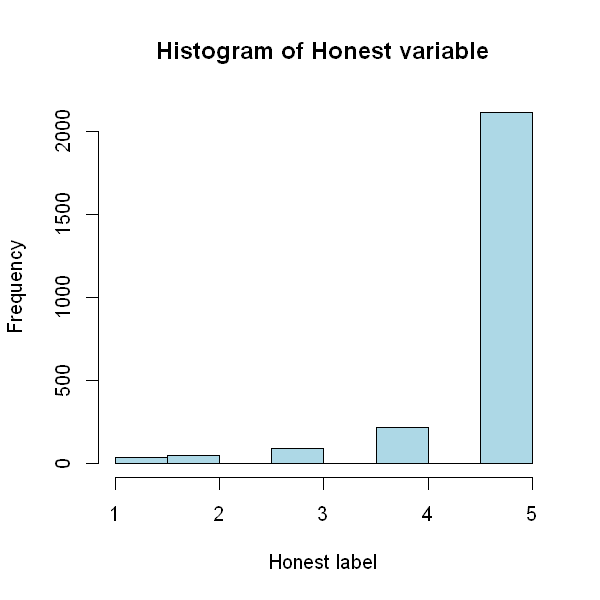

In [33]:
# EDA for honest
paste("Summary for honest")
summary(d$honest)

paste("Percentage of always honest respondents")
as.numeric(nrow(d[d$honest == 5,]) / nrow(d)) * 100

hist(d$honest, main = "Histogram of Honest variable", xlab = "Honest label", col = "lightblue", border = "black")

[1] "Summary for nonserious"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.491   1.000   5.000 

[1] "Percentage of nonserious=[1,2,3] respondents"

[1] 90.92

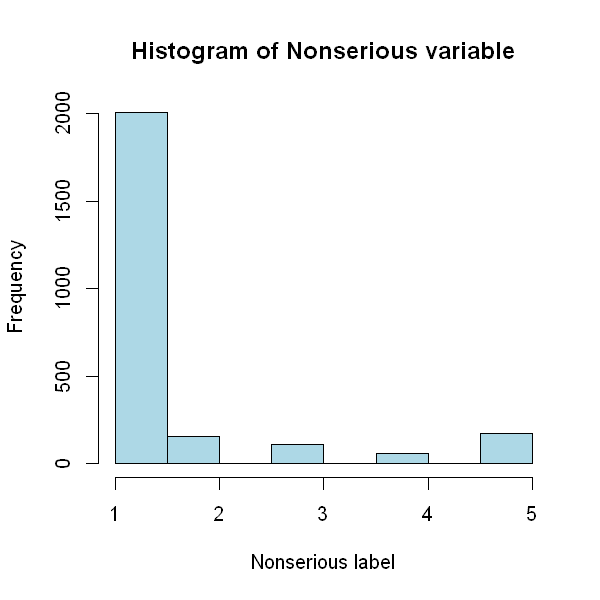

In [34]:
# EDA for nonserious
paste("Summary for nonserious")
summary(d$nonserious)

paste("Percentage of nonserious=[1,2,3] respondents")
as.numeric(nrow(d[d$nonserious %in%  c(1,2,3),]) / nrow(d)) * 100

hist(d$nonserious, main = "Histogram of Nonserious variable", xlab = "Nonserious label", col = "lightblue", border = "black")

#### Let's construct our base data set (q1_data)

In [35]:
# create base data set 
q1_data = get_data()

# consider only "always honest" respondents 
q1_data = filter_honest(q1_data, c(5))

# consider respondents with _page_timing less than equal to 30 seconds
q1_data = filter_timing(q1_data, "ftpolice", 30)
q1_data = filter_timing(q1_data, "ftjournal", 30)

# consider only respondents with nonseriousness levels 1,2,3 
q1_data = filter_nonserious(q1_data, c(1,2,3))

nrow(q1_data)

[1] 1882

In [36]:
# We further slice our data on the basis of very serious vs our population of serious [1,2,3] respondents
q1_data_serious = filter_nonserious(q1_data, c(1))
nrow(q1_data_serious)/nrow(q1_data) * 100

[1] 95.90861

#### We notice that the very serious (nonserious=1) population is a large portion of the data we are working with.  So we will decide NOT to conduct separate tests for very serious (nonserious=1) vs semi serious (nonserious=[1,2,3]) 

In [37]:
# we further investigate the ftpolice_skp and ftjournal_skp variables

# EDA for ftpolice_skp
paste("Summary for ftpolice_skp")
summary(q1_data$ftpolice_skp)

paste("Percentage of non-zero ftpolice_skp")
as.numeric(nrow(q1_data[q1_data$ftpolice_skp %in%  c(1),]) / nrow(q1_data)) * 100
# < 1% of the respondents chose to skip the ftpolice question. This shows the respondents are not hesitant!

# EDA for ftjournal_skp
paste("Summary for ftjournal_skp")
summary(q1_data$ftjournal_skp)

paste("Percentage of non-zero ftjournal_skp")
as.numeric(nrow(q1_data[q1_data$ftjournal_skp %in%  c(1,2),]) / nrow(q1_data)) * 100
# < 1% of the respondents chose to skip the ftjournal question. This shows the respondents are not hesitant!

[1] "Summary for ftpolice_skp"

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000000 0.004782 0.000000 1.000000 

[1] "Percentage of non-zero ftpolice_skp"

[1] 0.4782147

[1] "Summary for ftjournal_skp"

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000000 0.007439 0.000000 2.000000 

[1] "Percentage of non-zero ftjournal_skp"

[1] 0.6376196

#### We conclude that there were very few (< 1%) of respondents from our base data set that chose to skip the ftpolice or ftjournal question. So we will NOT conduct further tests based on skp=0 vs all skp.

#### Basic Analysis of ftpolice and ftjournal

[1] "Summary for ftpolice"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   50.00   72.00   66.55   91.00  100.00 

[1] "Unique values for ftpolice"

[1]  48  73  38  78  90  46  64  82  95  23  72  81  94  86  80  60  50  96
 [19]   3  91  20  14  71  52 100  89   6  84  75  99  85  88  41  10  83  97
 [37]  66  61  63  57  76  58  55  87  51  70  22  98  69  68  65  93  74  77
 [55]  62  79  59  92  15  67   0  43  13  42  30   1  25  29   4  40   5  54
 [73]  49   7  28  21   9  19  45  56  35  32  18  12  31  24  44   8  47  27
 [91]  34  11  53   2  33  16  17  36  26  39

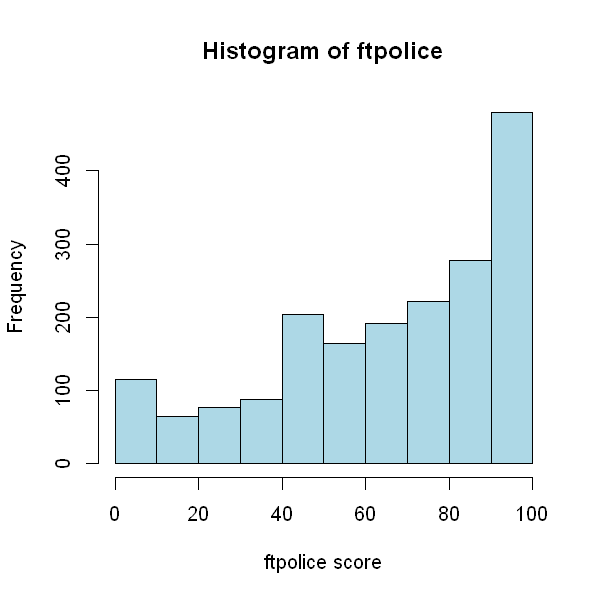

In [41]:
paste("Summary for ftpolice")
summary(q1_data$ftpolice)

paste("Unique values for ftpolice")
unique(q1_data$ftpolice)
# we observe there are no "invalid" values (negative values, values outside of 0-100)

hist(q1_data$ftpolice, xlab = "ftpolice score", main = "Histogram of ftpolice", col = "lightblue", border = "black")

#### Due to the ordinal and likert nature of the ftpolice score, we cannot construct any distribution of the variable. 
#### However, we notice a skewness in high respect for police based on the histogram.  

[1] "Summary for ftjournal"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -7.00   20.00   53.00   52.84   85.00  100.00 

[1] "Unique values for ftjournal"

[1]  85  77  23  88  30  50  83  97   0  68  94  49 100  10  48  51  79  76
 [19]  11  44  67  96  63  99  98  20  31  18  87  71  80  -7  72  41  90   5
 [37]  89  86  92  66  70  34  29  95  78  93  16  35  19  82  21  12  84  14
 [55]   6  91   2  73  60  75  28  59  38  13   7  54   3  15  26   4   9  37
 [73]  33   1   8  69  46  42  57  36  22  81  17  65  39  62  55  52  56  53
 [91]  74  40  27  47  32  61  58  64  45  43  25  24

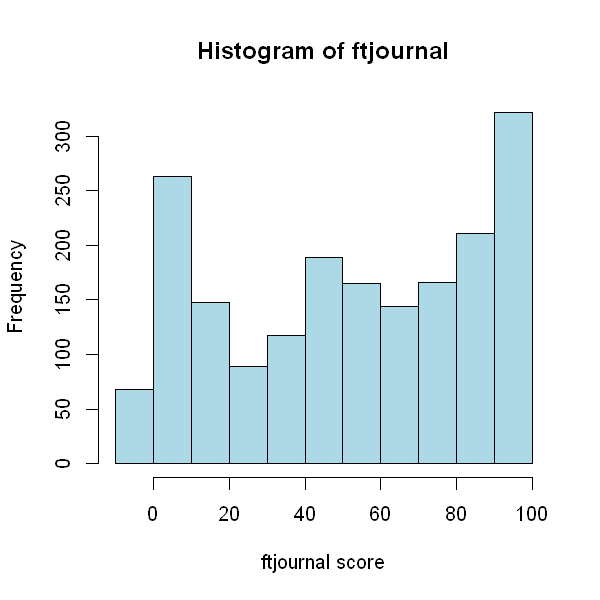

In [43]:
paste("Summary for ftjournal")
summary(q1_data$ftjournal)

paste("Unique values for ftjournal")
unique(q1_data$ftjournal)
# we observe there are negative values for ftjournal, which is also evident from the histogram

hist(q1_data$ftjournal, xlab = "ftjournal score", main = "Histogram of ftjournal", col = "lightblue", border = "black")


#### Due to the ordinal and likert nature of the ftjournal score, we cannot construct any distribution of the variable. 
#### However, we notice an almost bi-modal nature in ftjournal score - people are divided on their respect levels for journalists  

In [44]:
# we notice there are values for ftjournal < 0, so we need to remove these rows as they are missing values
paste("ftjournal scores less than 0")
nrow(q1_data[q1_data$ftjournal < 0,])

paste("ftjournal scores >= 0")
q1_data = q1_data[q1_data$ftjournal >= 0,]
nrow(q1_data)

[1] "ftjournal scores less than 0"

[1] 2

[1] "ftjournal scores >= 0"

[1] 1880

In [48]:
# sanity check on having the right values for our tests
nrow(q1_data[q1_data$ftjournal >= 0 & q1_data$ftpolice >= 0,]) == nrow(q1_data)
nrow(q1_data[q1_data$ftjournal <= 100 & q1_data$ftpolice <= 100,]) == nrow(q1_data)

[1] TRUE

[1] TRUE

### Based on your EDA, select an appropriate hypothesis test. (5 points)

Few observations:

1. The measurements are likert variables, we cannot say that the difference between 5 and 6 is the same between 89 and 90. These are NOT metric values.
2. Having said that, a score of 89 is more favorable than a score of 5 **(ordinal behavior)**.
3. However, these are **comparable in measurement across groups** because they are measured on the SAME scale and measured against the SAME audience.
4. The distribution of both ftpolice and ftjournal cannot be determined due to likert nature. **So we will have to use "non parametric tests"**.
5. Note that we are NOT interested in "how much more" do US voters respect police vs journalists. We are interested in "which group is respected more". Specifically, **we are interested in the sign of the test** where the sign indicates which side US voters respect more. Note that because we use non-parametric signed tests, we are throwing out information of the likert scale.
6. These are **paired measurements against the same individual across 2 groups** - journalists and policemen.
7. Notice sample size is large, n > 40.
8. Hence, we will conduct a paired non parametric test, specifically, the **Signed test for Dependent Samples**
9. We **could have performed a Wilcoxon Signed-Rank test for paired data**, but that will answer the question - "How much more / less are the police respected compared to journalists by US Voters?". That answers a different question from the one being asked, although it would have more statistical power than the signed test. 

Assumptions:

1. We can assume as per instructions in the lab that each pair of ftpolice and ftjournal, say (p, j) are IID.
2. We do have an ordinal scale for measurement (0 to 100 therm scale)

Consequence:
1. Because we are throwing away all our likert information, we **lose some statistical power with the signed test.**

Hypothesis:

1. Let plus = number of total events of seeing ftpolice > ftjournal
2. Let minus = number of total events of seeing ftpolice < ftjournal
3. Here, plus ~ Binomial(n, 0.5)

**Ho: Prob(plus) = Prob(minus)**

**Ha: Prob(plus) != Prob(minus)**

### Conduct your test. (5 points)

In [55]:
equal_hat = nrow(q1_data[q1_data$ftpolice == q1_data$ftjournal,])
plus_hat = nrow(q1_data[q1_data$ftpolice > q1_data$ftjournal,])
minus_hat = nrow(q1_data[q1_data$ftpolice < q1_data$ftjournal,])
total_hat = as.numeric(equal_hat + plus_hat + minus_hat)
# ignore equal scores of ftjournal and ftpolice for binomial test
n = total_hat - equal_hat

paste("ftpolice == ftjournal:", equal_hat)
paste("ftpolice > ftjournal:", plus_hat)
paste("ftpolice < ftjournal:", minus_hat)
paste("total:", total_hat)
paste("total - equal:", n)

# binomial test
p = 0.5
mean = n * p
threshold = abs(plus_hat - mean)
paste("The mean:", mean)
paste("The threshold:", threshold)
# p value is prob that |plus - mean| >= threshold
# to find p value
# P(plus - 910.5 >= 122.5) and P(910.5 - plus >= 122.5)
# P(plus >= 1033) and P(plus <= 788)

binom.test(x = c(plus_hat, minus_hat), n, p = 0.5, alternative = c("two.sided"), conf.level = 0.95)

[1] "ftpolice == ftjournal: 59"

[1] "ftpolice > ftjournal: 1033"

[1] "ftpolice < ftjournal: 788"

[1] "total: 1880"

[1] "total - equal: 1821"

[1] "The mean: 910.5"

[1] "The threshold: 122.5"


	Exact binomial test

data:  c(plus_hat, minus_hat)
number of successes = 1033, number of trials = 1821, p-value =
1.027e-08
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.5441470 0.5901774
sample estimates:
probability of success 
             0.5672707 


#### The above shows that we reject the null hypothesis as the p value is very small. We see that probabilities of the number of successes in the 2 groups is NOT equal.

#### We see probability of success is around 56%. This implies that the US voters do like policemen more than journalists.

In [63]:
# infact, if we did the test one sided, where the alternative is that Prob(# fav. ftpolice scores) > Prob(# fav. ftjournal scores) 
binom.test(x = c(plus_hat, minus_hat), n, p = 0.5, alternative = c("greater"), conf.level = 0.95)


	Exact binomial test

data:  c(plus_hat, minus_hat)
number of successes = 1033, number of trials = 1821, p-value =
5.134e-09
alternative hypothesis: true probability of success is greater than 0.5
95 percent confidence interval:
 0.5478283 1.0000000
sample estimates:
probability of success 
             0.5672707 


**Effect Size For Signed Test**

1. We can think of the proportion of police population as the effect size
2. We can also think of (plus_hat - minus_hat) / n as the effect size


In [60]:
plus_hat/n

[1] 0.5672707

In [61]:
(plus_hat - minus_hat)/n

[1] 0.1345415

#### We can conclude that there is a real difference between the respect levels for police vs journalists. US voters respect the police more!